# Multi Layer Perceptron

In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
!pip install --upgrade pandas scikit-learn seaborn pyarrow

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Carregando os dados

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_all = pd.read_parquet("/content/drive/MyDrive/capture24/Participants_all.parquet")

In [6]:
df_all.head()

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,label:WillettsSpecific2018_enc,label:WillettsMET2018,label:WillettsMET2018_enc,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos
0,P001,2016-11-13 02:18:00,2016-11-13 02:18:05,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.468161,0.004565,-0.482334,-0.46669,-0.537512,0.006892,-0.548902,-0.533341,0.657518,0.003960,0.643077,0.673867,0.219195,0.288966,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.0,0.0,0.566406,0.824126
1,P001,2016-11-13 02:18:05,2016-11-13 02:18:10,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470069,0.006437,-0.482334,-0.46669,-0.537045,0.006771,-0.548902,-0.517780,0.657702,0.003627,0.643077,0.673867,0.221007,0.288463,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,0.0,0.0,0.566706,0.823920
2,P001,2016-11-13 02:18:10,2016-11-13 02:18:15,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469694,0.006162,-0.482334,-0.46669,-0.537947,0.007104,-0.548902,-0.533341,0.657764,0.003369,0.643077,0.673867,0.220650,0.289438,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.0,0.0,0.567005,0.823714
3,P001,2016-11-13 02:18:15,2016-11-13 02:18:20,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469287,0.005821,-0.482334,-0.46669,-0.537512,0.006962,-0.548902,-0.517780,0.657733,0.003567,0.643077,0.673867,0.220264,0.288967,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.0,0.0,0.567305,0.823508
4,P001,2016-11-13 02:18:20,2016-11-13 02:18:25,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470820,0.006896,-0.482334,-0.46669,-0.535333,0.005291,-0.548902,-0.517780,0.658226,0.002743,0.643077,0.673867,0.221719,0.286609,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,0.0,0.0,0.567604,0.823302


In [7]:
df_all.shape

(1843551, 37)

In [8]:
# coluna da atividade alvo
TARGET = "label:Walmsley2020"

In [9]:
label2enc = (
    df_all[["label:Walmsley2020","label:Walmsley2020_enc"]]
    .drop_duplicates()
    .set_index("label:Walmsley2020")["label:Walmsley2020_enc"]
    .sort_index()
    .to_dict()
)

In [11]:
label2enc

{'light': 0, 'moderate-vigorous': 1, 'sedentary': 2, 'sleep': 3}

In [10]:
enc2label = {
    v: k for k, v in label2enc.items()
}

In [12]:
enc2label

{0: 'light', 1: 'moderate-vigorous', 2: 'sedentary', 3: 'sleep'}

## Preparação do Data Set Para o MLP
Separação de treino e teste

Verficação de Nas

Pre-processamento: one hot-encoding, standard scaling

### Separação em treino e teste

In [13]:
#features baseadas em aceleração
features_acc = [
    'x_mean', 'x_std','x_min', 'x_max',
    'y_mean', 'y_std', 'y_min', 'y_max',
    'z_mean','z_std', 'z_min', 'z_max',
    'energy_x', 'energy_y', 'energy_z','energy_total',
    'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
    'fft_dom_freq', 'fft_peak_power'
]


#features de contexto, não baseadas em aceleração.
features_cont = ['sex', 'age_group', 'hour_sin', 'hour_cos']

In [14]:
cols_corr = ["corr_xy", "corr_xz", "corr_yz"]
df_all[cols_corr] = df_all[cols_corr].fillna(0)

### Conforme decisão na primeira versão do notebook MLP_Model vamos retirar P043 para teste

In [15]:
df_all_test = df_all[df_all['pid']=='P043'].reset_index(drop=True)
df_all_train = df_all[df_all['pid']!='P043'].reset_index(drop=True)

In [16]:
#target
y_train = df_all_train['label:Walmsley2020_enc']
y_test = df_all_test['label:Walmsley2020_enc']

#features apenas com variáveis numéricas de aceleração (22 features)
X_acc_train= df_all_train[features_acc]
X_acc_test= df_all_test[features_acc]

#features com variáveis numéricas de aceleração e features de contexto (26 features)
X_all_train = df_all_train[features_acc+features_cont]
X_all_test = df_all_test[features_acc+features_cont]

### Pre-processamento: standard scaling + one hot-encoding

In [17]:
def build_preprocessor(X_train):
    '''sex não é escalado → mantido como 0/1
    age_group é one-hot
    numeric_features recebem scaler
    ordem das colunas é garantida'''

    # 1. Definir grupos de features
    categorical_features = ["age_group"] if "age_group" in X_train.columns else []

    # variáveis que NÃO devem ser transformadas (mantidas como estão)
    passthrough_features = []
    if "sex" in X_train.columns:
        passthrough_features.append("sex")

    # numéricas contínuas = todas as outras
    numeric_features = [
        col for col in X_train.columns
        if col not in categorical_features + passthrough_features
    ]

    # 2. Transformadores
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    )

    # 3. ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
            ("pass", "passthrough", passthrough_features),
        ],
        remainder="drop"
    )

    # 4. Fit no treino
    preprocessor.fit(X_train)

    # 5. Construção correta dos nomes finais
    # numéricas escaladas
    out_num = numeric_features

    # categorias one-hot
    out_cat = (
        preprocessor.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
        if categorical_features else []
    )

    # binárias mantidas (sexo)
    out_pass = passthrough_features

    feature_names = out_num + out_cat + out_pass

    return preprocessor, feature_names

In [18]:
def apply_preprocessor(preprocessor, X, feature_names):
    X_trans = preprocessor.transform(X)
    return pd.DataFrame(X_trans, columns=feature_names, index=X.index)

### V1 — só aceleração

In [19]:
prep_v1, feat_v1 = build_preprocessor(X_acc_train)
X_v1_train = apply_preprocessor(prep_v1, X_acc_train, feat_v1)
X_v1_test  = apply_preprocessor(prep_v1, X_acc_test, feat_v1)

### V2 — aceleração + contexto

In [20]:
prep_v2, feat_v2 = build_preprocessor(X_all_train)
X_v2_train = apply_preprocessor(prep_v2, X_all_train, feat_v2)
X_v2_test  = apply_preprocessor(prep_v2, X_all_test, feat_v2)

## MLP

### Duas possíveis arquiteturas

In [21]:
#Versão mais robusta para rodar no colab
def build_mlp_baseline(n_features, n_classes):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Dense(256, input_shape=(n_features,), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.4))

    # Layer 2
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    # Layer 3
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))

    # Output
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

In [22]:
#Versão mais leve para V1
def build_mlp_light(n_features, n_classes):
    model = models.Sequential()

    model.add(layers.Dense(128, input_shape=(n_features,), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(32, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

### Compilador

In [23]:
def compile_mlp(model, lr=1e-3):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Critérios a serem usados no fit

In [24]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [25]:
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {
    cls: weight for cls, weight in zip(np.unique(y_train), class_weight_values)
}

In [26]:
class_weights

{np.int64(0): np.float64(1.3521519436195204),
 np.int64(1): np.float64(5.203890506300323),
 np.int64(2): np.float64(0.6284736195139371),
 np.int64(3): np.float64(0.676994194510528)}

### Rodar no google colab apenas com variáveis de aceleração e arquitetura light

In [27]:
n_features = X_v1_train.shape[1] #X_v1_train ou X_v2_train
X_train_tensor = X_v1_train.to_numpy().astype(np.float32)

n_classes = 4
y_train_onehot = to_categorical(y_train, num_classes=n_classes)


In [28]:
model = build_mlp_baseline(n_features, n_classes)  # build_mlp_light ou build_mlp_baseline
model = compile_mlp(model, lr=1e-3)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Primeiro treino

In [29]:
history = model.fit(
    X_train_tensor,
    y_train_onehot,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

Epoch 1/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6837 - loss: 0.7811 - val_accuracy: 0.7311 - val_loss: 0.6777
Epoch 2/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7321 - loss: 0.6941 - val_accuracy: 0.7450 - val_loss: 0.6510
Epoch 3/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7391 - loss: 0.6784 - val_accuracy: 0.7472 - val_loss: 0.6590
Epoch 4/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7433 - loss: 0.6714 - val_accuracy: 0.7501 - val_loss: 0.6467
Epoch 5/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.7445 - loss: 0.6666 - val_accuracy: 0.7461 - val_loss: 0.6699
Epoch 6/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7468 - loss: 0.6612 - val_accuracy: 0.7399 - val_loss: 0.6901
Epoch 7/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7478 - loss: 0.6615 - val_accuracy: 0.7449 - val_loss: 0.6657
Epoch 8/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - ac

## Avaliação resultados

### Criação do ypred

In [32]:
X_test_tensor = X_v1_test.values.astype("float32")
y_test_onehot = to_categorical(y_test, num_classes=4)

In [33]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_onehot, verbose=1)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7988 - loss: 0.5663
Test accuracy: 0.7444874048233032
Test loss: 0.6462153196334839


In [34]:
y_pred_proba = model.predict(X_test_tensor)

413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [35]:
y_pred = y_pred_proba.argmax(axis=1)

### Macro F1

In [36]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)

Macro F1: 0.6872388236000729


In [37]:
f1_per_class = f1_score(y_test, y_pred, average=None)
f1_named = {
    enc2label[i]: f1_per_class[i]
    for i in range(len(f1_per_class))
}
for label, f1_value in sorted(f1_named.items(), key=lambda x: x[1], reverse=True):
    print(f"{label:20s}  F1 = {f1_value:.4f}")

sleep                 F1 = 0.9218
light                 F1 = 0.7167
sedentary             F1 = 0.6497
moderate-vigorous     F1 = 0.4609


### Matriz de confusão

In [38]:
cm = confusion_matrix(y_test, y_pred)

In [40]:
labels_order = [enc2label[i] for i in range(4)]

cm_df = pd.DataFrame(
    cm,
    index=labels_order,
    columns=labels_order
)

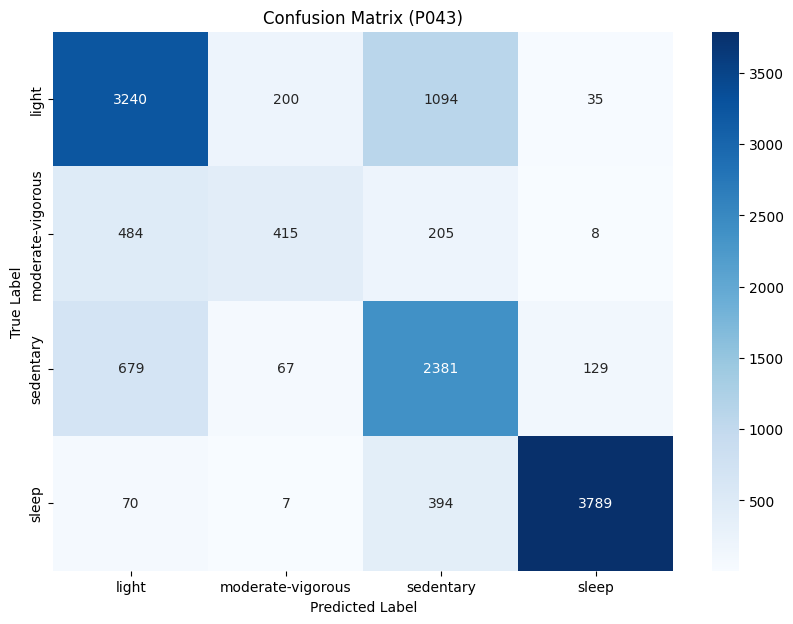

In [41]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (P043)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Resumo dos resultados

In [42]:
summary = {
    "test_accuracy": float(test_accuracy),
    "test_loss": float(test_loss),
    "macro_f1": float(macro_f1),
    "f1_per_class": f1_named,
    "confusion_matrix": cm_df
}

In [43]:
print("=== Summary for Participant P043 ===\n")

print(f"Test Accuracy:   {summary['test_accuracy']:.4f}")
print(f"Test Loss:       {summary['test_loss']:.4f}")
print(f"Macro F1:        {summary['macro_f1']:.4f}\n")

print("F1 per class:")
for label, value in summary["f1_per_class"].items():
    print(f"  {label:20s} {value:.4f}")

print("\nConfusion Matrix:")
display(summary["confusion_matrix"])

=== Summary for Participant P043 ===

Test Accuracy:   0.7445
Test Loss:       0.6462
Macro F1:        0.6872

F1 per class:
  light                0.7167
  moderate-vigorous    0.4609
  sedentary            0.6497
  sleep                0.9218

Confusion Matrix:


,light,moderate-vigorous,sedentary,sleep
light,3240,200,1094,35
moderate-vigorous,484,415,205,8
sedentary,679,67,2381,129
sleep,70,7,394,3789


In [44]:
model.save('/content/drive/MyDrive/capture24/models/mlp_v1_4classes_p043.keras')
